# Explore SSH model field

This notebook:
1) Opens the ECCO v4r4 SSH field
2) Calculates the difference between the two points selected in our EMU mask across the Drake Passage
3) Produces plots to show the time series of $\Delta$ SSH<br>
<br>
*Updated by M Zahn Oct 18, 2024*

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42205")
client

<Client: 'tcp://127.0.0.1:42205' processes=4 threads=8, memory=61.46 GiB>

In [3]:
import numpy as np
import ecco_v4_py as ecco
import xarray as xr
import matplotlib.pyplot as plt
import ecco_access as ea
from os.path import join,expanduser

# identify user's home directory
user_home_dir = expanduser('~')

## Open ECCOv4r4 SSH

In [4]:
ssh_shortname = "ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4"
access_mode = 's3_open_fsspec'
download_root_dir = join(user_home_dir,'efs_ecco','ECCO_V4r4_PODAAC')
jsons_root_dir = join(user_home_dir,'efs_ecco','mzz-jsons')

In [5]:
ssh_ds = ea.ecco_podaac_to_xrdataset(ssh_shortname,\
                                     StartDate='1992-01',EndDate='2017-12',\
                                     mode=access_mode,\
                                     download_root_dir=download_root_dir,\
                                     max_avail_frac=0.5,\
                                     jsons_root_dir=jsons_root_dir)

In [6]:
drake_pt = ssh_ds.SSH.isel(i=88,j=60,tile=11)
antar_pt = ssh_ds.SSH.isel(i=6,j=70,tile=12)

In [7]:
d_ssh = (drake_pt-antar_pt)

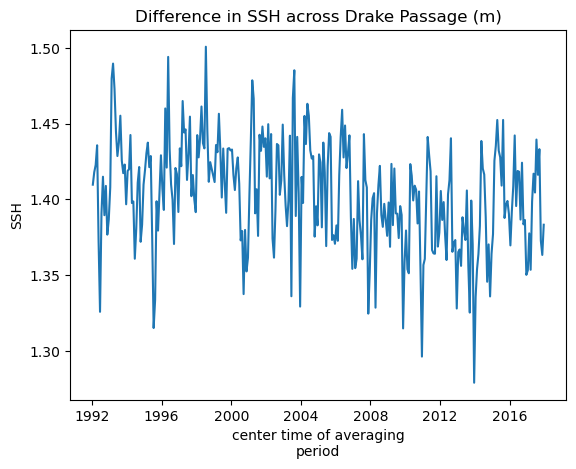

In [8]:
d_ssh.plot();
plt.title("Difference in SSH across Drake Passage (m)");

## Calculate geostrophic flow

v = (g / f) * (∂η / ∂x)

In [9]:
g = -9.81
f = -1.2e-4

In [10]:
# distance along transect
drake_pt.XC.values
drake_pt.YC.values

array(-56.2021, dtype=float32)

Need to install haversine to calculate distance between the two points

In [16]:
from haversine import haversine

In [17]:
dx = haversine((-56.2021,-67.5),(-60.330074,-57.5),unit='m')

In [18]:
transport = (g/f) * d_ssh / dx

In [19]:
# convert to Sverdrups and multiply over rough depth of 1000 m
transport_Sv = (transport / 1e6) * 1000 * dx

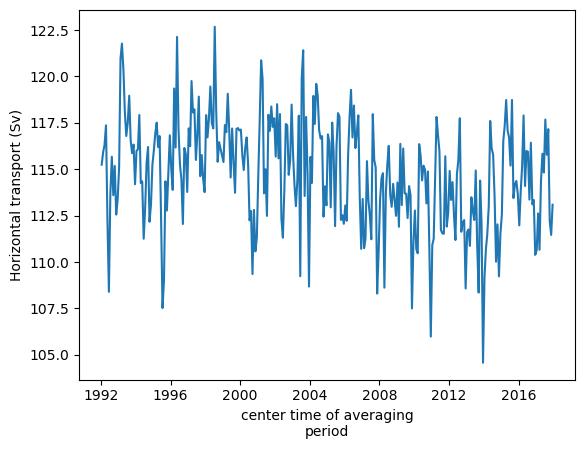

In [20]:
transport_Sv.plot();
plt.ylabel('Horizontal transport (Sv)');

Expected transport through Drake Passage is ~120-150 Sv so this looks reasonable!

## Plot EMU sampling tool

Path to sampling output:<br>
`/efs_ecco/mzahn/emu_samp_m_1_drake_ssh_mask.bin_1_20241016_152835`

Found file: /efs_ecco/ECCO/EMU/emu_userinterface_dir/emu_env.singularity
EMU Input Files directory: /efs/owang/ECCO/EMU_test/emu_input_dir



Enter directory of EMU run to examine; e.g., emu_samp_m_2_45_585_1 ... ?  /efs_ecco/mzahn/emu_samp_m_1_drake_ssh_mask.bin_1_20241016_152835



Reading /efs_ecco/mzahn/emu_samp_m_1_drake_ssh_mask.bin_1_20241016_152835

Reading Sampling Tool output ... 

*********************************************
Read variables
   smp: temporal anomaly of sampled variable
   smp_mn: reference time-mean of sampled variable
from file /efs_ecco/mzahn/emu_samp_m_1_drake_ssh_mask.bin_1_20241016_152835/output/samp.out_312

*********************************************
Read variable
   smp_hr: sample time (hours from 1/1/1992 12Z)
from file /efs_ecco/mzahn/emu_samp_m_1_drake_ssh_mask.bin_1_20241016_152835/output/samp.step_312

Plotting sampled time-series ... 


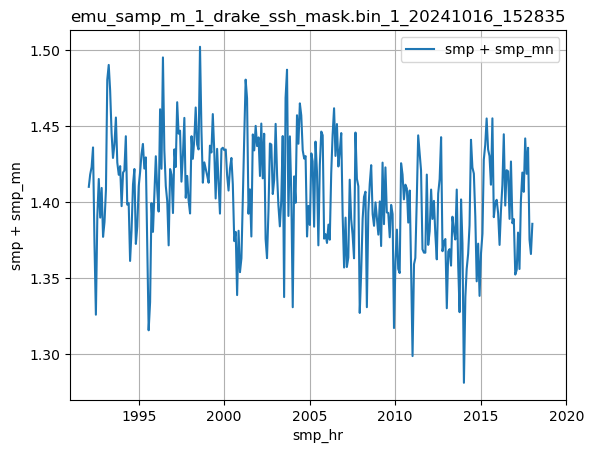


***********************
EMU variables read as global variables in module global_emu_var (emu); e.g., emu.nx
***********************
cs                  drc                 drf                 dvol3d              
dxc                 dxg                 dyc                 dyg                 
hfacc               hfacs               hfacw               nr                  
nx                  ny                  rac                 ras                 
raw                 raz                 rc                  rf                  
smp                 smp_hr              smp_mn              sn                  
xc                  xg                  yc                  yg                  


In [22]:
import runpy
runpy.run_path('/efs_ecco/ECCO/EMU/emu_userinterface_dir/python/emu_plot.py');

This matches what I calculated above!